# Мобильные приложения — Выделение групп пользователей на основе поведения


## Обзор данных

Импортируем библиотеки, которые понадобятся в ходе выполнения проекта.

In [39]:
import pandas as pd
import numpy as np
import datetime as dt
import re
from statsmodels.stats.proportion import proportions_ztest

from matplotlib import pyplot as plt
import seaborn as sns

# настройки для визуализаций:

sns.set_style('darkgrid') # стиль отображения графиков
sns.set_palette('terrain', 9, desat=0.7)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 7 #размер отображаемых графиков
rcParams['axes.titlesize'] = 16 # размер заголовков графиков
rcParams['axes.labelsize'] = 13 # размер подписей к осям

sns.color_palette()

[(0.18810457516339874, 0.46261437908496733, 0.7426143790849673),
 (0.10499999999999998, 0.5949999999999999, 0.595),
 (0.28909803921568633, 0.7414901960784315, 0.4614901960784316),
 (0.6359999999999999, 0.86, 0.58),
 (0.9363490196078431, 0.9355803921568627, 0.6576117647058825),
 (0.7538, 0.7145999999999999, 0.5382),
 (0.563949019607843, 0.48478039215686275, 0.4140117647058824),
 (0.5796, 0.5012000000000001, 0.48440000000000005),
 (0.7939215686274509, 0.7554901960784314, 0.7472549019607843)]

Загрузим данные о событиях и источниках трафика и сохраним их в переменные `sources` и `events`.

In [40]:
path = '...'
sources, events = (
    pd.read_csv(path + '/mobile_sources.csv'),
    pd.read_csv(path + '/mobile_dataset.csv')
)

Ознакомимся с каждой из таблиц: проверим структуру, наличие пропусков и дубликатов, типы данных.

In [41]:
display(sources.sample(3))
sources.info()

,userId,source
1614,09d9b380-46f9-4167-b80c-a7ae49bd096a,google
1260,64821486-e7f8-4204-933b-96f8388ab177,google
2321,1af91ec7-e097-4a89-bd62-78cd0b6401e8,yandex


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


Датасет `sources` содержит колонки:
+ `userId` — идентификатор пользователя;
+ `source` — источник, с которого пользователь установил приложение.

В датасете 4293 строки, пропусков нет.  Типы данных в порядке.  Стоит поправить названия колонок, поискать дубликаты.

In [42]:
display(events.sample(3))
events.info()

,event.time,event.name,user.id
6600,2019-10-09 18:57:23.269616,tips_show,a86c8ecd-2d72-4f4b-92e1-387968d0e4a4
41176,2019-10-23 14:48:08.537568,photos_show,05b35678-bbc6-47f0-b552-ab639249a0d4
52185,2019-10-27 02:41:49.446790,contacts_show,abc47bf2-6ed0-432b-bc23-bd1adf4f29bc


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Датасет `events` содержит колонки:
+ `event.time` — время совершения;
+ `event.name` — название события;
+ `user.id` — идентификатор пользователя.

Расшифровка событий в колонке `event.name`:
+ *advert_open* — открытие карточки объявления;
+ *photos_show* — просмотр фотографий в объявлении;
+ *tips_show* — пользователь увидел рекомендованные объявления;
+ *tips_click* — пользователь кликнул по рекомендованному объявлению;
+ *contacts_show* и *show_contacts* — пользователь нажал на кнопку "посмотреть номер телефона" на карточке объявления;
+ *contacts_call* — пользователь позвонил по номеру телефона на карточке объявления;
+ *map* — пользователь открыл карту размещенных объявлений;
+ *search_1 — search_7* — разные события, связанные с поиском по сайту;
+ *favorites_add* — добавление объявления в избранное.

В датасете 74 197 строк, пропусков нет. Следует скорректировать названия столбцов, привести тип данных колонки времени совершения действия к *datetime*, поискать дубликаты.

## Предобработка данных


Начнём с преобразования названий столбцов в обеих таблицах. Поскольку менять надо все заголовки, можно сделать это неявно.

In [43]:
sources.columns = ['user_id', 'source']
events.columns = ['event_datetime', 'event_name', 'user_id']

Теперь изменим тип данных в колонке `event_timestamp` таблицы `events`, а также создадим на её основе колонку `event_dt` лишь с датой события.

In [44]:
events['event_datetime'] = events['event_datetime'].astype('datetime64[s]')
events.insert(loc=1, column='event_dt', value=events['event_datetime'].astype('datetime64[D]'))
events.dtypes # проверка

event_datetime    datetime64[ns]
event_dt          datetime64[ns]
event_name                object
user_id                   object
dtype: object

Далее в таблице `sourсes` проверим уникальные значения в колонке с названием источника трафика `source`.

In [45]:
sources['source'].value_counts()

yandex    1934
other     1230
google    1129
Name: source, dtype: int64

Отлично: всего три, все разные, распределение не вызывает вопросов. Тут же проверим таблицу на наличие дубликатов.

In [46]:
display(f'Количество дубликатов в таблице: {sources.duplicated().sum()}')

'Количество дубликатов в таблице: 0'

С таблицей `sources` разобрались.

Переходим к таблице `events`. Проверим уникальные значения в колонке `event_name` — все ли они соответствуют описанию таблицы

In [47]:
events['event_name'].value_counts()

tips_show        40055
photos_show      10012
advert_open       6164
contacts_show     4450
map               3881
search_1          3506
favorites_add     1417
search_5          1049
tips_click         814
search_4           701
contacts_call      541
search_3           522
search_6           460
search_2           324
search_7           222
show_contacts       79
Name: event_name, dtype: int64

Соответствуют.

Заменим события *show_contacts* на *contacts_show* — согласно описанию они идентичны.


In [48]:
events['event_name'] = events['event_name'].replace('show_contacts', 'contacts_show')

Теперь можно проверить таблицу `events` на наличие дубликатов.

In [49]:
display(f'Количество дубликатов в таблице: {events.duplicated().sum()}')

'Количество дубликатов в таблице: 1143'

Едва ли возможно совершение нескольких одинаковых действий одним пользователем в одно время с точностью до секунды, поэтому от дубликатов избавляемся.

И теперь можно также объединить все события *search_1—7* в одно событие *search*. Из ТЗ неясно, чем они отличаются — можно предположить, что это какие-то фильтры поиска, поэтому это объединение проводим *после* удаления дубликатов: несколько фильтров теоретически могут быть применены одновременно.

In [50]:
events = events.drop_duplicates().reset_index(drop=True)
display(f'Количество дубликатов в таблице: {events.duplicated().sum()}')

events['event_name'] = events['event_name'].apply(lambda x: re.sub("[^a-z]", "", x) if r'search' in x else x)

'Количество дубликатов в таблице: 0'

И, наконец, проверим, интервал дат для данных в нашем распоряжении.

In [51]:
print(f'Данные за период с {events["event_datetime"].min()} по {events["event_datetime"].max()},\n'
      f'то есть почти {(events["event_datetime"].max() - events["event_datetime"].min()).round("1D").days} дней.')

Данные за период с 2019-10-07 00:00:00 по 2019-11-03 23:58:12,
то есть почти 28 дней.


И совпадают ли вообще идентификаторы пользователей в двух таблицах.

In [52]:
if set(sources['user_id']) == set(events['user_id']):
    print('идентификаторы пользователей в таблицах совпадают ✔')
else:
    print('идентификаторы пользователей в таблицах не совпадают ❌')


идентификаторы пользователей в таблицах совпадают ✔


### Вывод

Была проведена предобработка данных: названия колонок приведены к "змеиному" регистру, колонки с датами — к типу данных *datetime*. В таблице `events` добавлен отдельный столбец с датой — `event_dt`.

Проверена корректность временного промежутка и строковых значений в данных, идентичные типы событий (колонка `event_name` в таблице `event`) объединены под единым именем.

Проведена проверка на наличие дубликатов и их удаление.

## Исследовательский анализ данных

### Retention Rate

#### Создание профилей пользователей

Создадим таблицу `profiles` с пользовательскими профилями, в которых будет отражена дата первого посещения и источник перехода в приложение.

In [53]:
# отсортируем сессии по id пользователя и времени совершения события 
# сгруппируем по id и найдём первые значения event_datetime
# столбец с временем первого посещения назовём first_ts

profiles = (
    events.sort_values(by=['user_id', 'event_datetime'])
    .groupby('user_id')
    .agg({'event_datetime': 'first'})
    .rename(columns={'event_datetime': 'first_ts'})
    .reset_index()  # возвращаем user_id из индекса
    )

# добавляем столбец с датой первого посещения
profiles['dt'] = profiles['first_ts'].dt.date

# и, объединяя с таблицей sources, получаем колонку источника, из которого пришёл в приложение пользователь
profiles = profiles.merge(sources, on='user_id')

display(f'в таблице {profiles.shape[0]} строк')
profiles.head()

'в таблице 4293 строк'

,user_id,first_ts,dt,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45,2019-10-07,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33,2019-10-19,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,2019-11-01,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05,2019-10-18,google
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,2019-10-25,yandex


Результат — 4293 пользовательских профиля, в каждом из которых есть данные о дате первого посещения и рекламном источнике, который мотивировал пользователя посетить приложение.

Тут же посмотрим сразу и на динамику привлечения новых пользователей по каждому из рекламных каналов.

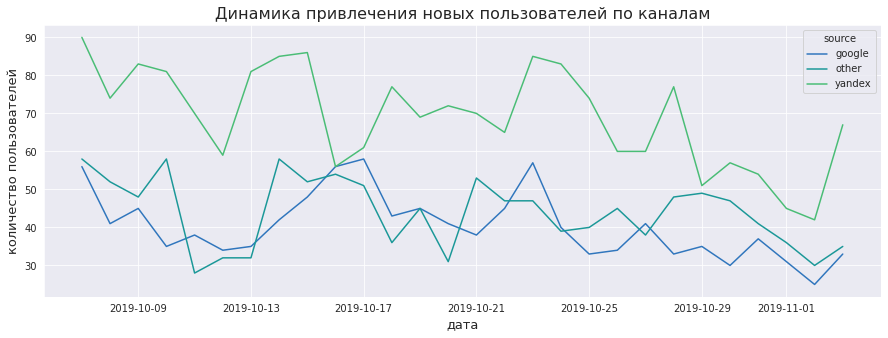

In [54]:
profiles.pivot_table(
    index='dt',  # даты первых посещений
    columns='source',  # источники переходов
    values='user_id',  # id пользователей
    aggfunc='nunique'  # подсчёт уникальных значений
).plot(figsize=(15, 5), grid=True)
plt.title('Динамика привлечения новых пользователей по каналам')
plt.xlabel('дата')
plt.ylabel('количество пользователей')
plt.show()

Все источники отличаются стабильностью: количество привлекаемых ими пользователей не опускается ниже определённого уровня. *yandex* показывает лучшие результаты, *google* и *other* примерно одинаковые. Приток пользователей из всех источников снижается в конце октября — начале ноября.

#### Построение таблицы удержания

Для расчёта коэффициента удержания напишем функцию `get_retention()`. 

Её аргументы: 

- `profiles` — профили пользователей,
- `sessions` — данные журнала сессий,
- `observation_date` — момент анализа,
- `horizon_days` — горизонт анализа в днях,
- `dimensions` — дополнительный параметр для группировки,
- `ignore_horizon` — опция «игнорировать горизонт анализа», по умолчанию `False`.

In [55]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=False
):
    dimensions = ['dt'] + dimensions # параметр для группировки

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'event_datetime']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_datetime'] - result_raw['first_ts']
    ).dt.days

    # рассчитываем удержание
    result_grouped = result_raw.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Получаем таблицу удержания с моментом анализа 3/11/2019 — последняя дата в доступных данных, — и горизонтом анализа 7 дней.

In [56]:
retention_raw, retention = get_retention(
    profiles, events, dt.datetime(2019, 11, 3).date(), 7,
)

retention

,cohort_size,0,1,2,3,4,5,6
dt,,,,,,,,
2019-10-07,204,1.0,0.122549,0.098039,0.107843,0.053922,0.039216,0.058824
2019-10-08,167,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892
2019-10-09,176,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818
2019-10-10,174,1.0,0.091954,0.103448,0.080460,0.097701,0.080460,0.068966
2019-10-11,136,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.073529
2019-10-12,125,1.0,0.128000,0.160000,0.056000,0.064000,0.088000,0.080000
2019-10-13,148,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054
2019-10-14,185,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.054054
2019-10-15,186,1.0,0.139785,0.091398,0.080645,0.053763,0.053763,0.080645


#### Визуализация 

Для визуализации показателя RR построим тепловую карту по когортам.

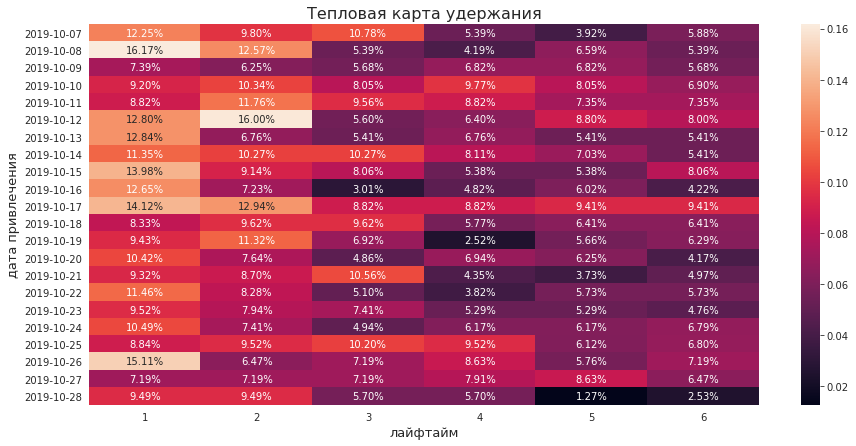

In [57]:
sns.heatmap(retention.drop(columns = ['cohort_size', 0]), # удаляем размеры когорт и нулевой лайфтайм
            annot = True,  # подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')
plt.xlabel('лайфтайм')
plt.ylabel('дата привлечения')
plt.show()

По светлым пятнам на графике видно, что лучшее удержание на второй день показали пользователи, привлечённые 8-ого и 26-ого октября , а на третий — привлечённые 12 октября. 

В среднем удержание седьмого дня составляет около 6 %, но разброс большой: от 2,53% до 9,41%. 

На протяжении рассматриваемого горизонта анализа лучший результат у когорты 17 октября, а наименее успешный — у когорты 28 октября.

### Анализ времени, проведённого пользователями в приложении

#### Выделение сессий пользователей



Для более точного анализа выделим пользовательские сессии. Тогда различные временные метрики можно будет рассчитывать в разрезе этих сессий, чтобы не учитывать ситуации когда пользователь совершал действия с большим временным разрывом.

Стандартно для реконструкции сессий за предел продолжительности сессии приниается интервал в 30 минут между действиями пользователя, либо же используются пользовательские периоды пребывания в мобильном приложении.
или и вовсе реализуется подход, ориентированный на навигацию.

Здесь за предел продолжительности сессии возьмём 25 минут — субъективно оценённый временной интервал, после истечения которого уже сложно считать пользователя отвлёкшимся на уведомление в мессенджере или переход между станциями метро; присвоим каждой сессии каждого ползователя идентификатор.

In [58]:
# сохраняем в переменную sessions события, отсортированные по id пользователя и времени совершения
sessions = events.sort_values(['user_id', 'event_datetime']).reset_index(drop=True)

# разница между timestamp'ами событий
diff_timestamp = sessions.groupby('user_id')['event_datetime'].diff()

# индексы строк, где будет начинаться новая сессия
# устанавливаем гэп между сессиями — 25 минут
new_session = (diff_timestamp.isnull()) | (diff_timestamp > pd.Timedelta('25Min'))

# создаём уникальный идентификатор сессии для кадого пользователя
sessions['session_id'] = sessions.loc[new_session, ['user_id', 'event_datetime']] \
    .groupby('user_id').rank(method='first').astype(int)

# Заменим оставшиеся пропуски последним определённым id сессии
sessions['session_id'] = sessions['session_id'].fillna(method='ffill').astype(int)
sessions.iloc[90:95] # check

,event_datetime,event_dt,event_name,user_id,session_id
90,2019-10-29 22:10:25,2019-10-29,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,5
91,2019-10-30 07:50:45,2019-10-30,search,00157779-810c-4498-9e05-a1e9e3cedf93,6
92,2019-10-30 07:53:12,2019-10-30,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,6
93,2019-10-30 07:54:25,2019-10-30,photos_show,00157779-810c-4498-9e05-a1e9e3cedf93,6
94,2019-10-30 07:55:09,2019-10-30,search,00157779-810c-4498-9e05-a1e9e3cedf93,6


#### Продолжительность сессий

Теперь посчитаем продолжительность каждой пользовательской сессии. Отобразим её в секундах в таблице `session_duration`, куда занесём  id пользователя и его сессии, время первого и последнего действия в течение сессии.

In [59]:
session_duration = sessions.groupby(['user_id', 'session_id']).agg({'event_datetime':['min', 'max']}).reset_index()
session_duration.columns = session_duration.columns.droplevel(0)
session_duration.columns=['user_id', 'session_id', 'first_ts', 'last_ts']
session_duration['session_duration_sec'] = (session_duration['last_ts'] - session_duration['first_ts'])\
                                        .astype('timedelta64[s]').astype('int')
session_duration = session_duration.query('session_duration_sec != 0') # сразу откинем "нулевые" сессии:
                                                                # это либо "остатки" данных с предыдущего периода, 
                                                                # либо случайные входы в приложение.
# колонка с продолжительностью сессии в минутах:
session_duration['session_duration_minutes'] = round(session_duration['session_duration_sec'] / 60, 1)
session_duration.sample(3)

,user_id,session_id,first_ts,last_ts,session_duration_sec,session_duration_minutes
4924,78cba3cc-14e0-4d95-b4ce-e0c1ab0133e3,1,2019-10-30 23:41:12,2019-10-30 23:54:13,781,13.0
946,14e35c14-02f3-4894-ab62-9ad165b50130,1,2019-10-23 13:36:45,2019-10-23 13:43:15,390,6.5
9727,e802f163-f542-4254-a2d2-ccbbcedeabc7,1,2019-10-28 09:02:05,2019-10-28 09:13:36,691,11.5


❗ При удалении "нулевых" сессий из таблицы также должны пропасть и пользователи, у которых только такие сессии и были.

Посмотрим на распределение продолжительности сессий среди всех пользователей, для упрощения восприятия — в минутах. 

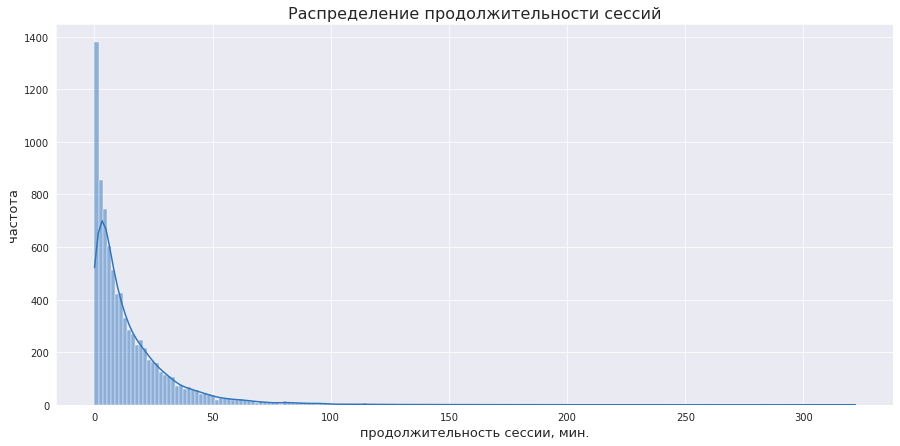

In [60]:
sns.histplot(session_duration['session_duration_minutes'], kde=True)
plt.title('Распределение продолжительности сессий')
plt.xlabel('продолжительность сессии, мин.')
plt.ylabel('частота')
plt.show()

Поближе рассмотрим распределение без "хвоста", чтобы можно было заметить пики, если они есть.

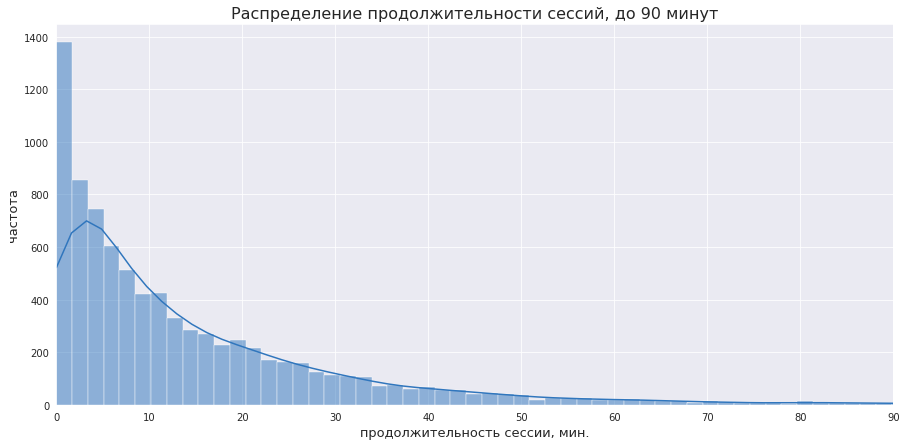

In [61]:
a = sns.histplot(session_duration['session_duration_minutes'], kde=True)
plt.title('Распределение продолжительности сессий, до 90 минут')
plt.xlabel('продолжительность сессии, мин.')
plt.ylabel('частота')
a.set(xlim=(0,90))
plt.show()

Очень много сверхкоротких сессий, но в целом распределение в порядке, нет аномальных выбросов.


In [62]:
print(
    f"Средняя продолжительность сессии: {(session_duration['session_duration_minutes'].mean()).round(1)} минут\n"
    f"Медианная продолжительность сессии: {(session_duration['session_duration_minutes'].median()).round(1)} минут"
)

Средняя продолжительность сессии: 15.0 минут
Медианная продолжительность сессии: 8.9 минут


Проверим, что за события совершались в эти сверхкороткие сессии.

In [63]:
# очевидно, не самый точный способ, но быстрый и, думаю, достаточный, чтобы оценить примерно
(sessions.query(
    "event_datetime in @session_duration.query('session_duration_sec <= 1')['first_ts']"
    )
 ['event_name'].value_counts())

photos_show      14
tips_show        12
search           10
contacts_show     2
advert_open       1
favorites_add     1
Name: event_name, dtype: int64

Похоже, что это "обрывки" сессий, которые были разделены установленным интервалом между сессиями в 25 минут. Но событий не так много, а универсальный интервал для всех пользователей подобрать невозможно.

### Частота совершения пользователями событий

Посмотрим на распределение частоты совершаемых событий в целом.

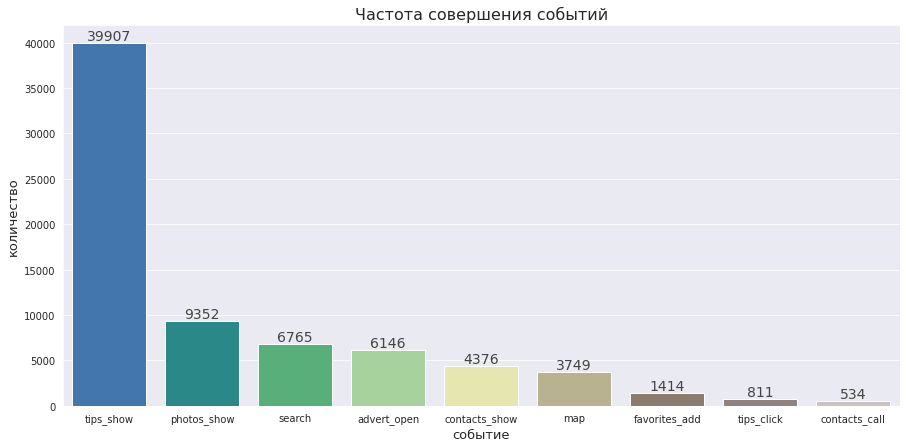

In [64]:
events_cnt = events.groupby('event_name')['event_datetime'].count()\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'event_datetime':'event_count'})

sns.barplot(x=events_cnt['event_name'], 
            y=events_cnt['event_count'],)
            
for i, val in enumerate(events_cnt['event_count'].values):
    plt.text(i, val, round(val, 2), horizontalalignment='center', verticalalignment='bottom', color='#444444', fontsize=14)

plt.title('Частота совершения событий')
plt.xlabel('событие')
plt.ylabel('количество')
plt.show()

И также динамику изменения частоты событий по дням.

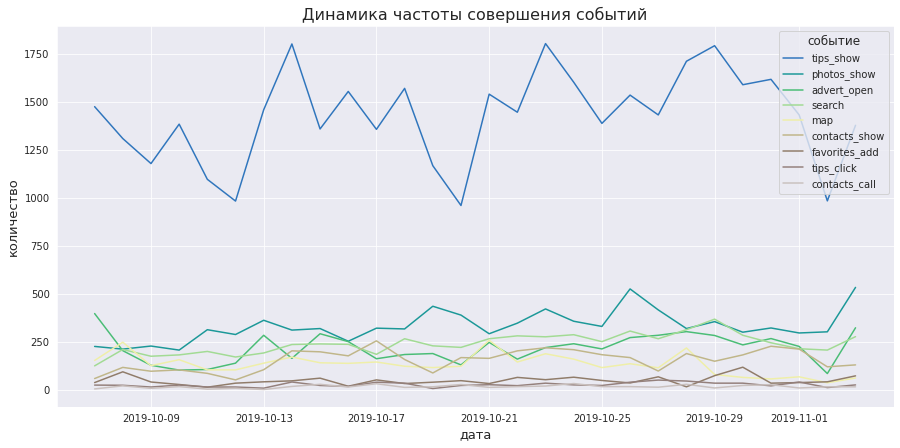

In [65]:
events_cnt_per_dt =  events.groupby(['event_name', 'event_dt'])['event_datetime'].count()\
                .sort_values(ascending=False)\
                .reset_index()\
                .rename(columns={'event_datetime':'event_count'})

sns.lineplot(data=events_cnt_per_dt, x='event_dt', 
            y='event_count', hue='event_name')

plt.title('Динамика частоты совершения событий')
plt.xlabel('дата')
plt.ylabel('количество')
plt.legend(title='событие', title_fontsize='large')
plt.show()

Кратно превышает количество других событий событие _"пользователь увидел рекомендованные объявления"_ — почти 40 тысяч записей за месяц. Также часто пользуются опцией просмотра фото, открытия карточки объявления и поиском.

Целевое действие — просмотр контактов — совершили 4 376 раз.

Динамика частоты совершения событий стабильна. Наибольшие флуктуации испытывает событие *tips_show*. Возможно, это связано с проведением рекламных кампаний.

### Активность пользователей

#### Количество событий на пользователя

Посчитаем, сколько событий приходится на пользователя.

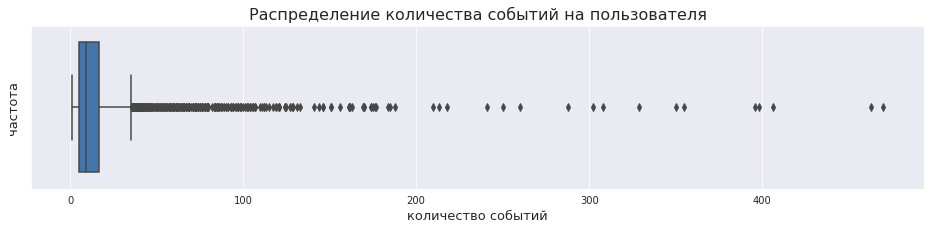

In [66]:
events_per_user = (sessions.groupby('user_id')['event_name']
                   .count()
                   .sort_values(ascending=False)
                   .reset_index()
                   .rename(columns={'event_name':'event_cnt'}))

plt.figure(figsize=(16,3))
sns.boxplot(x=events_per_user['event_cnt'])
plt.title('Распределение количества событий на пользователя')
plt.xlabel('количество событий')
plt.ylabel('частота')
plt.show()

In [67]:
print(
    f"Среднее количество событий на пользователя: {events_per_user['event_cnt'].mean().round(1)}\n"
    f"Медианное количество событий на пользователя: {events_per_user['event_cnt'].median().round(1)}"
)

Среднее количество событий на пользователя: 17.0
Медианное количество событий на пользователя: 9.0


Обычно пользователь совершает всего около 9 событий. Но есть и довольно много людей, которые очень активно используют приложение — у кого-то даже более 400 за обозреваемый месяц.

#### Количество сессий на пользователя

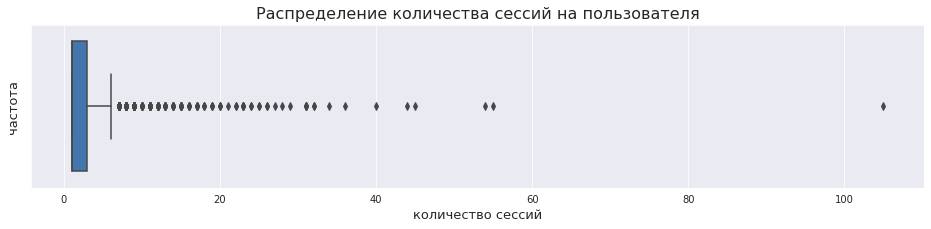

In [68]:
sessions_per_user = (sessions.groupby(['user_id'])['session_id']
                     .nunique()
                     .sort_values(ascending=False)
                     .reset_index()
                     .rename(columns={'session_id':'session_cnt'}))

plt.figure(figsize=(16,3))
sns.boxplot(x=sessions_per_user['session_cnt'])
plt.title('Распределение количества сессий на пользователя')
plt.xlabel('количество сессий')
plt.ylabel('частота')
plt.show()

In [69]:
print(
    f"Среднее количество сессий на пользователя: {sessions_per_user['session_cnt'].mean().round(1)}\n"
    f"Медианное количество сессий на пользователя: {sessions_per_user['session_cnt'].median().round(1)}"
)

Среднее количество сессий на пользователя: 2.5
Медианное количество сессий на пользователя: 1.0


А сессия у пользователей чаще всего одна (за обозреваемый месяц). Единичные пользователи совершают десятки сессий, и лишь один — более ста!

#### Количество событий за сессию

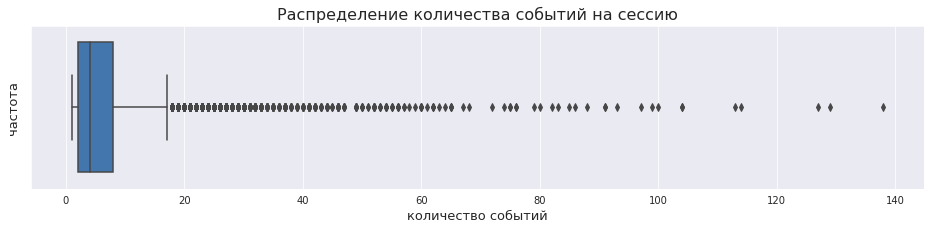

In [70]:
events_per_session = (sessions.groupby(['user_id', 'session_id'])['event_name']
                     .count()
                     .sort_values(ascending=False)
                     .reset_index()
                     .rename(columns={'event_name':'event_cnt'}))

plt.figure(figsize=(16,3))
sns.boxplot(x=events_per_session['event_cnt'])
plt.title('Распределение количества событий на сессию')
plt.xlabel('количество событий')
plt.ylabel('частота')
plt.show()

In [71]:
print(
    f"Среднее количество событий за сессию: {events_per_session['event_cnt'].mean().round(1)}\n"
    f"Медианное количество событий за сессию: {events_per_session['event_cnt'].median().round(1)}"
)

Среднее количество событий за сессию: 6.9
Медианное количество событий за сессию: 4.0


За одну сессию редко совершается более 20 событий, но есть и "залипающие" пользователи — вплоть до 140 событий в течение одной сессии!

### Время до совершения целевого действия

Интересно посмотреть, сколько времени проходит между первым действием в сессии и целевым действием (при его наличии).

In [72]:
# создаём таблицу с целевыми действиями, только с первыми в течение одной сессии у каждого пользователя
target_action = sessions.query('event_name=="contacts_show"')\
        .groupby(['user_id', 'session_id'])['event_datetime'].min().reset_index()\
        .rename(columns={'event_datetime':'target_datetime'})

# создаём таблицу с первыми действиями каждой сессии, если это не звонок (он по логике следует за цд)
first_action = sessions.query('event_name != "contacts_call"')\
        .groupby(['user_id', 'session_id']).agg({'event_datetime':'first', 'event_name':'first'}).reset_index()\
        .rename(columns={'event_datetime':'first_datetime','event_name':'first_event_name'})

# объединяем таблицы по всем пользователям и их сессиям, где было совершено цд
target_duration = target_action.merge(first_action, how='left', on=['user_id', 'session_id'])

# удаляем строки, где первое действие в сессии и являлось целевым — 
# возможно, это окончания сессий, не попавших полностью во временной интервал наших данных
target_duration = target_duration.query('first_event_name != "contacts_show"')

# рассчитываем столбец с временным интервалом с первого до целевого действия
target_duration['target_lag'] = (target_duration['target_datetime'] - target_duration['first_datetime'])\
        .astype('timedelta64[s]').astype('int')
    
target_duration.sample(3)

,user_id,session_id,target_datetime,first_datetime,first_event_name,target_lag
1653,f2dae072-c0f4-4be0-a923-bd626ecb717a,1,2019-10-28 16:39:28,2019-10-28 16:32:13,map,435
503,4e6eb20c-6a84-45b5-9cc2-f4ace35c5c31,1,2019-10-28 20:16:08,2019-10-28 20:14:01,search,127
834,82e10f7e-7283-4d4f-93a1-3710b00475be,10,2019-10-10 21:39:02,2019-10-10 21:25:36,tips_show,806


Построим распределение.

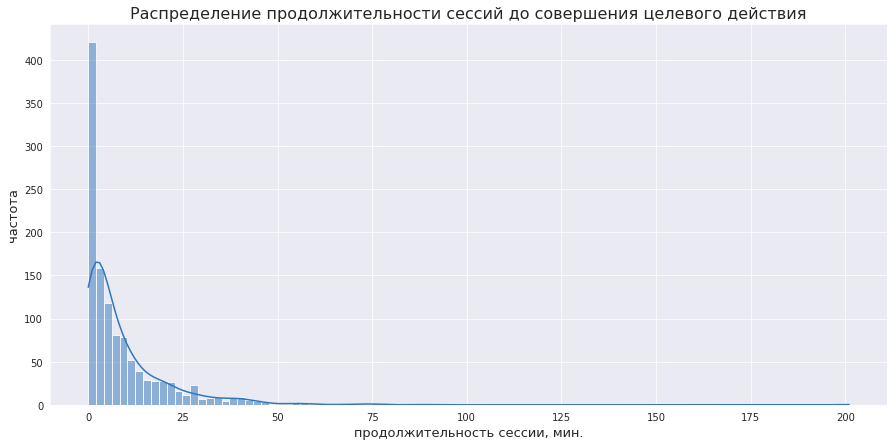

In [73]:
sns.histplot((target_duration['target_lag'] / 60).round(), kde=True)
plt.title('Распределение продолжительности сессий до совершения целевого действия')
plt.xlabel('продолжительность сессии, мин.')
plt.ylabel('частота')
plt.show()

In [74]:
print(
    f"Средняя продолжительность сессии: {(target_duration['target_lag'].mean() / 60).round(1)} минут\n"
    f"Медианная продолжительность сессии: {(target_duration['target_lag'].median() / 60).round(1)} минут"
)

Средняя продолжительность сессии: 9.0 минут
Медианная продолжительность сессии: 4.7 минут


А вот это интересно: сессии, которые таки приводят к совершению целевого действия, оказываются почти вдвое короче средней (и медианной, соответственно) продолжительности.

### Расчёт конверсии

Расчитаем общую конверсию пользователей в целевое действие — просмотр контактов, т.е. отношение количества пользователей, хоть раз совершивших целевое событие, к общему количеству пользователей.

In [75]:
# список пользователей, хоть раз посмотревших контакты
target_users = sessions.query('event_name == "contacts_show"')['user_id']

print('Доля пользователей, хотя бы раз совершивших целевое действие:', 
      round(target_users.nunique() / profiles.shape[0] * 100, 2), '%')

Доля пользователей, хотя бы раз совершивших целевое действие: 22.85 %


### Вывод

Проведён исследовательский анализ данных.

Созданы профили пользователей и выделены пользовательские сессии.

Произведён расчёт Retention Rate: пользователи скорее пользуются приложением не ежедневно, а заходят раз в несколько дней.  
В среднем удержание седьмого дня составляет около 6 %, но разброс большой: от 2,53% до 9,41%.  
Высокий и довольно стабильный показатель RR — у когорты 17 октября, а наименее успешный — у когорты 28 октября.

Средняя продолжительность сессии — 15 минут, медианная — почти 9 минут. Сессии, оканчивающиеся совершением целевого действия оказываются почти вдвое короче.

Кратно чаще других действий пользователи смотрят рекомендованные объявления — почти 40 тысяч записей за месяц. Также относительно популярные действия: просмотр фото, открытие карточки объявления и поиск.  
Целевое действие — просмотр контактов — совершили 4 376 раз.

*Чаще всего* на одного пользователя приходится 9 событий и, как правило, 1 сессия.  
При этом за одну сессию совершается обычно 4 события.  

При этом есть пользователи, проводящие в приложении много времени и совершающие много действий/сессий. Их количество невелико, однако кратно более высокие показатели существенно влияют на среднее.

Конверсия в целевое действие составляет 5,99%; 22,85% всех пользователей совершают его хотя бы раз.

## Сегментация пользователей



Для сегментации пользователей можно рассмотреть целый ряд признаков.  
Например:  
♦ по времени суток наибольшей активности,  
♦ по дням/неделям совершения первой сессии,  
♦ по источникам перехода в приложение,  
♦ по частоте сессий,  
♦ по количеству совершённых событий  
и др.

Поскольку в исследовательском анализе данных не было замечено, например, особой разницы в показателе RR по дневным когортам, зато была замечена разница в продолжительности всех сессий и сессий, окончившихся совершением целевого действия, *разделим пользователей по признаку средней продолжительности совершаемых ими сессий*.

Такое разделение потенциально *может выявить как технические проблемы, так и поведенческие.*  
К примеру, если пользователи с короткими сессиями не конвертируются совсем, что-то может прерывать их сессии (технический сбой на каком-то этапе) или сложности с во взаимодействии с интерфейсом (что-то сложно и непонятно — проще бросить, чем разобраться). Низкая конверсия в таких сессиях может означать недостаточную вовлечённость — рекомендации работают плохо, пользователь не увлекается.  
Или же очень длинные сессии, не приводящие к целевому действию, могут показать, что пользователей этого сегмента стоит "подтолкнуть" к финальному шагу — нерешительные ребята.

Посмотрим на распределение продолжительности сессий в целом.

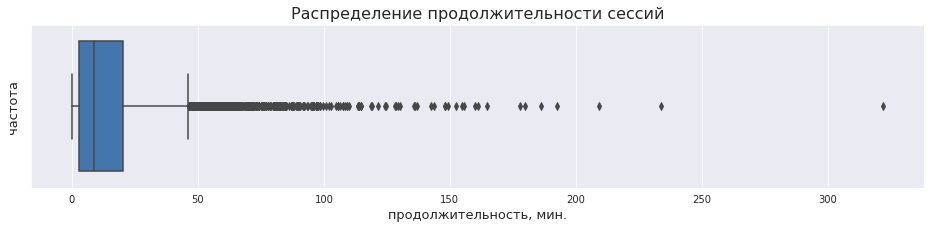

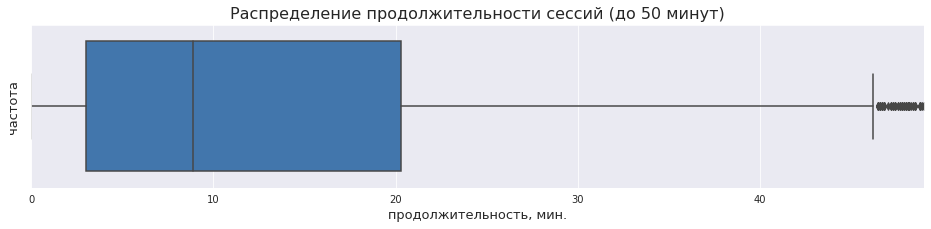

count    8396.000000
mean       15.040138
std        18.867593
min         0.000000
25%         3.000000
50%         8.900000
75%        20.300000
max       322.000000
Name: session_duration_minutes, dtype: float64

In [76]:
plt.figure(figsize=(16,3))
sns.boxplot(x=session_duration['session_duration_minutes'])
plt.title('Распределение продолжительности сессий')
plt.xlabel('продолжительность, мин.')
plt.ylabel('частота')
plt.show()

plt.figure(figsize=(16,3))
sns.boxplot(x=session_duration['session_duration_minutes'])
plt.title('Распределение продолжительности сессий (до 50 минут)')
plt.xlabel('продолжительность, мин.')
plt.ylabel('частота')
plt.xlim(0,49)
plt.show()

(session_duration['session_duration_minutes']).describe()

Будем делить пользователей на 4 группы по средней продолжительности сессий, которые они совершают, ориентируясь на квартили:  
♦ 1 группа — сессии до 3 минут,  
♦ 2 группа — сессии от 3 до 9 минут,  
♦ 3 группа — сессии от 9 до 20 минут,  
♦ 4 группа — сессии длиннее 20 минут (сверхдлинные отдельно выделять не будем).

In [77]:
# выделим среднюю продолжительность сессий у каждого пользователя

user_groups = (session_duration
               .groupby('user_id')['session_duration_sec'].mean()
               .reset_index()
               .rename(columns={'session_duration_sec': 'avg_session_duration'})
              )
user_groups['avg_session_duration'] = round(user_groups['avg_session_duration'] / 60, 1) # переводим в минуты
display(user_groups.sample(2))
print(f"❗ Количество пользователей, распределённых по группам: {user_groups.shape[0]} из {profiles.shape[0]}")

,user_id,avg_session_duration
3391,cecbc8e6-08ea-4f74-b3ce-d350237ab809,11.5
965,39c0652f-4caa-4e89-979f-056e3381c4e6,16.1


❗ Количество пользователей, распределённых по группам: 4206 из 4293


Напишем функцию для сегментирования пользователей `segmentation_user` и применим её к таблице `user_groups`.

In [78]:
# функция принимает на вход продолжительность сессии,
# возвращает группу пользователя в зависимости попадания значения между квартилями

def segmentation_user(duration):

    if duration <= session_duration['session_duration_minutes'].quantile(0.25).round():
        return 'A'
    if duration <= session_duration['session_duration_minutes'].quantile(0.5).round():
        return 'B'
    if duration <= session_duration['session_duration_minutes'].quantile(0.75).round():
        return 'C'
    return 'D'

In [79]:
user_groups['user_group'] = user_groups['avg_session_duration'].apply(segmentation_user)
user_groups.sample(3)

,user_id,avg_session_duration,user_group
3169,c2079a0b-bd78-416a-9702-c28446a89561,16.6,C
3214,c4e83fff-535d-43df-8b31-95eb5535636f,22.0,D
3362,ccf6d37b-635d-4b1b-a940-542eb3ab0639,14.6,C


Добавим столбец с группами в профили пользователей `profiles`, объединив таблицы по идентификатору.

In [80]:
profiles = profiles.merge(user_groups[['user_id', 'user_group']], on='user_id', how='left')
display(profiles.sample(3))
profiles['user_group'].value_counts() # проверка численности групп

,user_id,first_ts,dt,source,user_group
3067,b7c44ad0-e45e-42ae-b0db-8f23ee0b2a7c,2019-10-12 14:40:24,2019-10-12,google,A
1174,449d6ea1-eba9-4d67-bd13-f35ac9f0771c,2019-10-07 11:51:32,2019-10-07,other,C
1202,4682e1e5-626e-424c-9204-9770a65dbbce,2019-10-14 16:52:41,2019-10-14,yandex,C


C    1298
B    1216
D    1050
A     642
Name: user_group, dtype: int64

## Ответы на вопросы заказчика

Теперь, с разделением пользователей на группы, можно вновь посмотреть на метрики, отображающие поведение пользователей, чтобы ответить на вопросы заказчика

### Retention Rate по группам

*Пользователи какой группы склонны часто возвращаться в приложение?*

Снова сформируем таблицу удержания, используя функцию `get_retention`; теперь добавим разделение пользователей на группы.

In [81]:
retention_raw, retention = get_retention(
    profiles.query('not user_group.isna()'), events, dt.datetime(2019, 11, 3).date(), 7,  dimensions=['user_group'],
)

retention.head(8) # вид таблицы

cohort_size    0         1         2         3  \
dt         user_group                                                   
2019-10-07 A                    36  1.0  0.027778  0.083333  0.138889   
           B                    55  1.0  0.163636  0.109091  0.145455   
           C                    49  1.0  0.142857  0.102041  0.081633   
           D                    60  1.0  0.133333  0.083333  0.083333   
2019-10-08 A                    23  1.0  0.304348  0.130435  0.130435   
           B                    50  1.0  0.160000  0.120000  0.040000   
           C                    48  1.0  0.125000  0.104167  0.020833   
           D                    43  1.0  0.139535  0.162791  0.069767   

                              4         5         6  
dt         user_group                                
2019-10-07 A           0.027778  0.027778  0.027778  
           B           0.018182  0.072727  0.072727  
           C           0.081633  0.040816  0.102041  
           D           0.066667  0.016667  0.033333  
2019-10-08 A           0.043478  0.130435  0.043478  
           B           0.080000  0.100000  0.100000  
           C           0.020833  0.062500  0.000000  
           D           0.023256  0.000000  0.069767

Визуализируем результат, построив по тепловой карте для каждой группы.

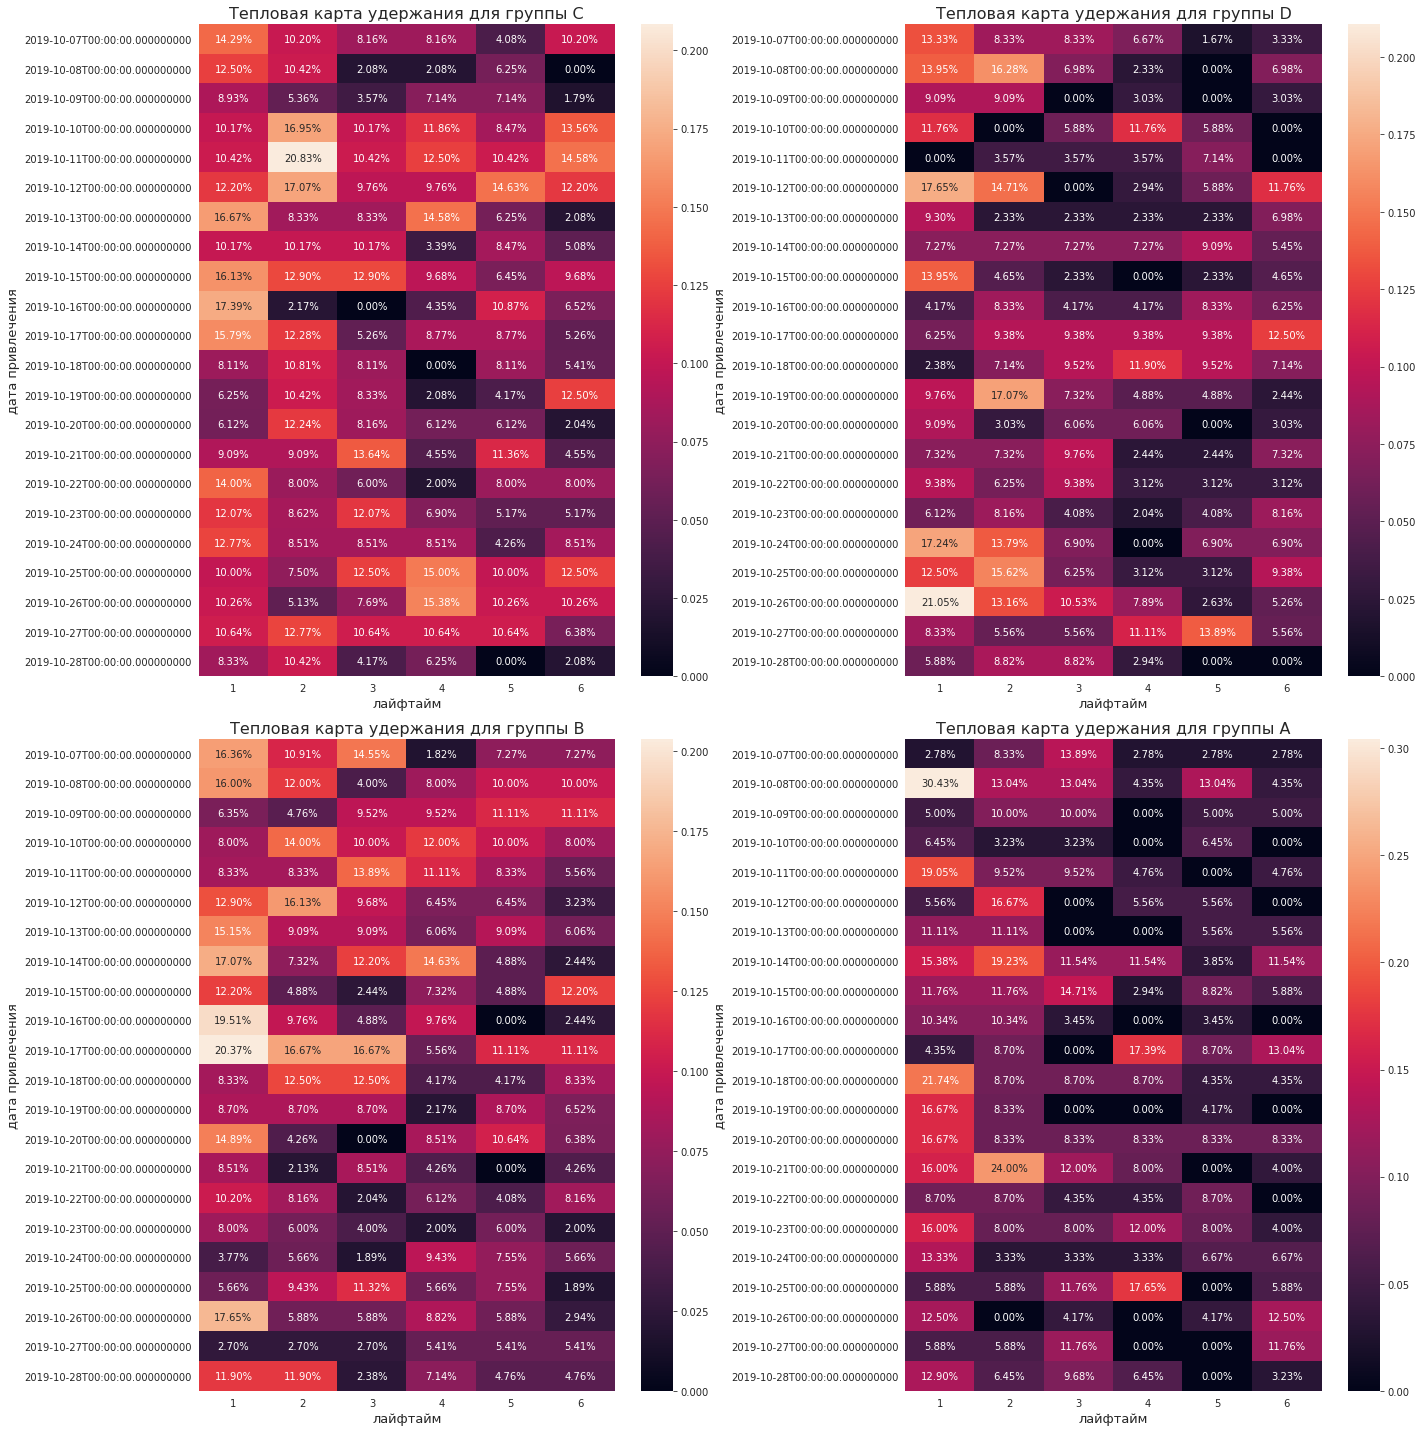

In [92]:
plt.figure(figsize=(20, 20)) # размер сетки для графиков

for i, gr in enumerate (profiles.query('not user_group.isna()')['user_group'].unique()): # только среди пользователей, 
                                                                                         # попавших в группы
    sns.heatmap(
        retention.query('user_group == @gr')
        # удаляем user_group из индексов, чтобы не загромождать графики:
        .droplevel('user_group')
        # исключаем размеры когорт и удержание первого дня:
        .drop(columns=['cohort_size', 0]),
        annot=True,
        fmt='.2%',
        # строим каждый график в своей ячейке:
        ax=plt.subplot(2, 2, i+1),
    )
    # задаём названия графиков с учётом значения user_group
    plt.title('Тепловая карта удержания для группы {}'.format(gr))
    plt.xlabel('лайфтайм')
    plt.ylabel('дата привлечения')

plt.tight_layout()  # «подгоняем» размер графиков, чтобы уместились подписи
plt.show()

С первого взгляда заметно, что хитмэпы для групп А и D темнее: за исключением пары дней пользователи в этих "экстремальных" группах (со сверхкороткими и сверхдлинными сессиями) "удерживаются" хуже.

Наиболее "стабильной" кажется группа С.  
Однако какого-то чёткого паттерна всё же не наблюдается.

### Конверсия в группах

*Пользователи какой группы чаще совершают целевое действие?*

Рассчитаем конверсию в цд в группах

In [45]:
# формируем таблицу с профилями тех пользователей, кто соверщал цд хоть раз:
target_profiles = profiles.query('user_id in @target_users.unique()')

# группируем по группам, считаем количество пользователей
target_profiles = (target_profiles.groupby('user_group')['user_id'].count()
                   .reset_index()
                   .rename(columns={'user_id':'target_user_cnt'})
                  )

# добавляем колонку с численностью групп
target_profiles['general_user_cnt'] = profiles.groupby('user_group')['user_id'].count().to_list()

# добавляем колонку с рассчитанной конверсией:
target_profiles['conversion'] = round(target_profiles['target_user_cnt'] / target_profiles['general_user_cnt'] * 100, 2)

target_profiles

,user_group,target_user_cnt,general_user_cnt,conversion
0,A,132,642,20.56
1,B,260,1216,21.38
2,C,302,1298,23.27
3,D,278,1050,26.48


И визуализируем результат.

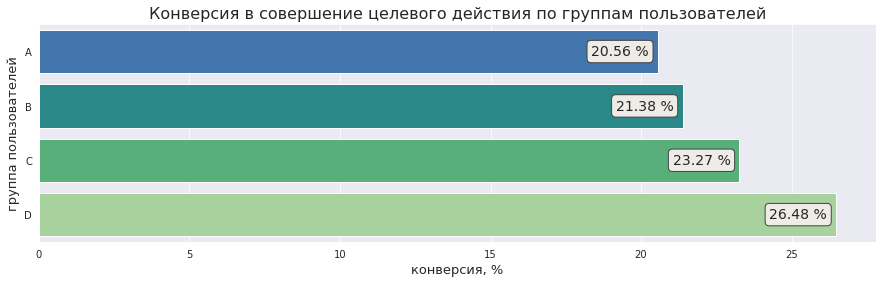

In [46]:
plt.figure(figsize=(15, 4))

sns.barplot(data=target_profiles, y='user_group', x='conversion')

for i, val in enumerate(target_profiles['conversion'].values):
    plt.text(val-0.3, i, "{} %".format(val),
             horizontalalignment='right',
             verticalalignment='center',
             #color='white',
             fontsize=14,
             weight='book',
             bbox=dict(facecolor='#efece7', edgecolor='#444444', boxstyle='round', pad=.3)
            )
    
plt.title('Конверсия в совершение целевого действия по группам пользователей')
plt.xlabel('конверсия, %')
plt.ylabel('группа пользователей')
plt.show()

Пользователи, зависающие в приложении (группа D), — самые конвертирующиеся! Даже лучше "средних". А вот конверсия "быстрых" скроллеров несколько уступает другим группам. Не успевают "зацепиться" за что-нибудь?

### Вывод

Была произведена сегментация пользователей на группы в соответствии с характерной для них продолжительностью сессий:  
♦ А — сверхкороткие,  
♦ В — средние короткие,  
♦ С — средние длинные,  
♦ D — сверхдлинные.

В разрезе такого разделения особенно выделяется группа А — здесь у пользователей заметно более низкое удержание и меньшая конверсия в целевое действие по сравнению с остальными группами. Проводя в приложении менее трёх минут за сессию, вероятно, легче отвлечься и забыть о понравившейся вещи и сложнее "зацепиться" за какое-то объявление. Возможно, этой группе стоит чаще отправлять пуш-уведомления с подборкой просмотренных ими страниц, чтобы вернуть их фокус.

Коэффициент удержания среди пользователей группы D (сверхдлинные сессии более 20 минут) начиная с 3-4-ого дня падает значительно. При этом, их конверсия превышает конверсию "средних", хорошо удерживающихся пользователей. То есть это люди, которые, возможно, прицельно и тщательно ищут что-то конкретное и, найдя, покидают приложение до появления следующего конкретного запроса. Если это так, то (при наличии технической возможности 🤷🏻‍♀️) можно анализировать веб-запросы (вне приложения) пользователя и предлагать ему решение проблемы на площадке приложения.

Что касается "средних" групп В и С, разница между ними не столь существенна, однако, тоже есть и соотносится со сравнением экстремальных групп: для вовлечённости нужно больше времени — пользователи, проводящие в приложении 9-20 минут, показывают лучшие метрики.

## Формулирование и проверка гипотез

### Гипотеза 1: зависимость конверсии от источника привлечения пользователей

Некоторые пользователи установили приложение по ссылке из `yandex`, другие — из `google`. Проверим, различается ли конверсия в просмотр контактов у двух этих групп.

Для этого сначала сформулируем *нулевую гипотезу* **Н0** и *альтернативную гипотезу* **Н1**:

**Н0**: конверсия пользователей, пришедших через _yandex_ ***равна*** конверсии пользователей, пришедших через _google_.

**Н1**: конверсия пользователей, пришедших через _yandex_ ***отличается*** от конверсии пользователей, пришедших через _google_.

Подготовим данные в таблице `target_profiles_by_source`

In [47]:
# формируем таблицу с профилями тех пользователей, кто соверщал цд хоть раз и пришёл из ya или google:
target_profiles_by_source = profiles.query('user_id in @target_users.unique() and source != "other"')

# группируем по источникам, считаем количество пользователей
target_profiles_by_source = (target_profiles_by_source.groupby('source')['user_id'].count()
                   .reset_index()
                   .rename(columns={'user_id':'target_user_cnt'})
                  )

# добавляем колонку с общим числом пользователей из каждого из источников
target_profiles_by_source['general_cnt'] = [profiles.query('source=="google"').shape[0], 
                                            profiles.query('source=="yandex"').shape[0]]

# добавляем колонку с рассчитанной конверсией:
target_profiles_by_source['conversion'] = round(
    target_profiles_by_source['target_user_cnt'] / target_profiles_by_source['general_cnt'] * 100, 2)

target_profiles_by_source

,source,target_user_cnt,general_cnt,conversion
0,google,275,1129,24.36
1,yandex,478,1934,24.72


Рассчитанные доли (в процентах) представляют собой долю успешных действий пользователя, т.к. за успех (целевое действие) мы принимаем факт совершения события просмотра контактов.

Доли посчитаны от общего количества пользователей из каждого источника, поэтому проверка гипотезы будет проводиться на независимых друг от друга данных.

Теперь мы можем проанализировать схожесть поведения пользователей в группах *yandex* и *google*.

Для этого используем proportion z тест: он считает количество успехов в анализируемой выборке, учитывая количество наблюдений, — т.е. позволяет проверить значимость в отличии в долях пользователей двух групп.

In [48]:
alpha = .05 # критический уровень статистической значимости

# напишем функцию, которая принимает на вход датафрейм с рассчитанными значениями,
# проверяет гипотезу о равенстве долей 
# и выводит результат проверки
def group_comparison(df):

    # определяем размер сравниваемых групп и рассматриваемые в них доли (конверсию)
    nobs = df['general_cnt']
    count = df['target_user_cnt']
    

    # проверяем гипотезу о равенстве долей (конверсии) для каждой группы
    stat, pval = proportions_ztest(count, nobs)

    # и выводим результат проверки
    print(f'p-value равно {pval:0.3f} =>')
    if pval < alpha:
        print(f'Отвергаем нулевую гипотезу: между долями {df.iat[0,0]} и {df.iat[1,0]} есть значимая разница')
    else:
        print(f'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли {df.iat[0,0]} и {df.iat[1,0]} разными') 

In [49]:
group_comparison(target_profiles_by_source)

p-value равно 0.824 =>
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли google и yandex разными


### Гипотеза 2: зависимость конверсии от факта добавления объявления в избранное

Некоторые пользователи добавляют объявление в избранное (=совершают событие *favorites_add*), другие не делают этого. Проверим, различается ли конверсия в просмотр контактов у двух этих групп.

Формулируем гипотезы:

**Н0**: конверсия пользователей, добавляющих объявления в избранное ***равна*** конверсии пользователей, не использующих эту функцию.

**Н1**: конверсия пользователей, добавляющих объявления в избранное ***отличается*** от конверсии пользователей, не использующих эту функцию.

Подготовим данные в таблице `target_profiles_add_fav`.

In [50]:
# формируем список пользователей, которые хотя бы раз пользовались функцией favorites_add
fav_add_users = sessions.query('event_name=="favorites_add"')['user_id'].unique()

# функция для маркировки пользователей той или иной группы
def is_fav_add_user(user):

    if user in fav_add_users:
        return True
    return False

Применяем функцию `is_fav_add_user` к таблице с пользовательскими профилями `profiles`.

In [51]:
profiles['is_fav_add'] = profiles['user_id'].apply(is_fav_add_user)
profiles.sample(3)

,user_id,first_ts,dt,source,user_group,is_fav_add
2209,842cd1d5-ef1d-4398-a1d6-93b1890676fc,2019-10-27 18:55:10,2019-10-27,other,A,False
185,0a9efcb4-c2c5-4440-ac37-5bf5323bed02,2019-10-28 10:38:18,2019-10-28,yandex,B,False
248,0e2657c4-f800-49c2-a1d1-8856086246ac,2019-10-19 20:12:40,2019-10-19,other,B,False


Теперь переходим к созданию таблицы `target_profiles_add_fav` с рассчётом конверсии в двух сравниваемых группах.

In [52]:
# формируем таблицу с профилями тех пользователей, кто соверщал цд хоть раз:
target_profiles_add_fav = profiles.query('user_id in @target_users.unique()')

# группируем по "добавлению в избранное", считаем количество пользователей
target_profiles_add_fav = (target_profiles_add_fav.groupby('is_fav_add')['user_id'].count()
                   .reset_index()
                   .rename(columns={'user_id':'target_user_cnt'})
                  )

# добавляем колонку с общим числом пользователей в группах
target_profiles_add_fav['general_cnt'] = [profiles.query('is_fav_add==False').shape[0], 
                                            profiles.query('is_fav_add==True').shape[0]]

# добавляем колонку с рассчитанной конверсией:
target_profiles_add_fav['conversion'] = round(
    target_profiles_add_fav['target_user_cnt'] / target_profiles_add_fav['general_cnt'] * 100, 2)

target_profiles_add_fav

,is_fav_add,target_user_cnt,general_cnt,conversion
0,False,845,3942,21.44
1,True,136,351,38.75


И применяем функцию `group_comparison`, которая проведёт z-тест (снова сравниваем доли — конверсии).

In [53]:
group_comparison(target_profiles_add_fav)

p-value равно 0.000 =>
Отвергаем нулевую гипотезу: между долями False и True есть значимая разница


### Вывод

Проведённые статистические тесты показали, что: 

1. конверсия в совершение целевого действия, по всей видимости, **не зависит** от источника привлечения пользователя (не удалось отвергнуть нулевую гипотезу о равенстве долей), поэтому нет смысла фокусироваться на рекламе в каком-то конкретном из этих источников;

2. конверсия в совершение целевого действия **зависит** добавления пользователем объявления в избранное (отвергнута гипотеза о равенстве долей): возможно, пользователю проще вернуться к понравившемуся объявлению после сравнения и обдумывания целесообразности покупки или просто после перерыва в сессии, поэтому следует развивать эту функцию (может быть, сделать кнопку более заметной).

## Выводы и рекомендации

В ходе выполнения проекта был проведён обзор, предобработка и исследовательский анализ данных.

Созданы профили пользователей и выделены пользовательские сессии.

Произведён расчёт Retention Rate: пользователи скорее пользуются приложением не ежедневно, а заходят раз в несколько дней.

Средняя продолжительность сессии — 15 минут, медианная — почти 9 минут. Сессии, оканчивающиеся совершением целевого действия, оказываются почти вдвое короче.

Кратно чаще других действий пользователи смотрят рекомендованные объявления — почти 40 тысяч записей за месяц, но крайне мало людей переходят к их просмотру.  
Также популярные действия: просмотр фото, открытие карточки объявления и поиск.
Целевое действие — просмотр контактов — совершили 4 376 раз.

Чаще всего на одного пользователя приходится 9 событий и, как правило, 1 сессия.
При этом за одну сессию совершается обычно 4 события.

22,85% всех пользователей совершают целевое действие хотя бы раз.

Была произведена сегментация пользователей на группы в соответствии с характерной для них продолжительностью сессий:

У группы А заметно более низкое удержание и наименьшая конверсия в целевое действие по сравнению с остальными группами.

Коэффициент удержания среди пользователей группы D (сверхдлинные сессии более 20 минут) начиная с 3-4-ого дня падает значительно. При этом, их конверсия является самой высокой среди рассматриваемых групп.

Группы В и С похожи, но их сравнение подтверждает, что для вовлечённости нужно больше времени — пользователи, проводящие в приложении 9-20 минут, показывают лучшие метрики.

Проведение статистических тестов на проверку гипотез о равенстве конверсий в группах пользователей показали, что конверсия в совершение целевого действия, по всей видимости, не зависит от источника привлечения пользователя; но зависит от добавления пользователем объявления в избранное.


**Рекомендации**:

♦ Стимулировать пользователей группы А (сверхкороткие сессии) к возвращению в приложение / увеличению продолжительности их сессий: по всей видимости, они не успевают "увлечься" и дойти до совершения целевого действия;

♦ Найти способ предлагать пользователям группы D (сверхдлинные сессии) нужные им товары, которые обычно они ищут вне приложения — это хорошо конвертирующиеся пользователи с низким удержанием;

♦ Развивать функцию добавления объявления в избранное: сделать кнопку более заметной или по прошествии некоторого времени предлать пользователю лайкнуть объявление, на просмотр которого он потратил много времени, например.